In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import ldspec
import zipfile

# autoreload
%load_ext autoreload
%autoreload 2

### Check plink

In [19]:
# Check 
# for CHR in [22]:
for CHR in range(1, 23):
    PGEN_FILE = "/n/scratch3/users/j/jz286/imp_geno/ukb_imp_chr@_v3"
    PGEN_FILE_CHIMP = "/n/scratch3/users/j/jz286/imp_geno_chimp/ukb_imp_chr@_v3_chimp"
    REF_FILE = '/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001/snp_info/ukb_imp_chr@_v3_aa.pvar'

    dic_data = gdreg.util.read_pgen(PGEN_FILE.replace("@", "%d" % CHR))
    dic_data_chimp = gdreg.util.read_pgen(PGEN_FILE_CHIMP.replace("@", "%d" % CHR))
    df_ref = pd.read_csv(REF_FILE.replace('@', '%d'%CHR), sep='\t')
    
    print('CHR %d' % CHR)
    print('CHIMP vs. REF_Chimp : n_dif=%d' % (dic_data_chimp['pvar']['REF']!=df_ref['REF_Chimp']).sum())
    print('CHIMP vs. ORI : n_dif=%d' % (dic_data_chimp['pvar']['REF']!=dic_data['pvar']['REF']).sum())


CHR 1
CHIMP vs. REF_Chimp : n_dif=0
CHIMP vs. ORI : n_dif=219227
CHR 2
CHIMP vs. REF_Chimp : n_dif=0
CHIMP vs. ORI : n_dif=237508
CHR 3
CHIMP vs. REF_Chimp : n_dif=0
CHIMP vs. ORI : n_dif=202197
CHR 4
CHIMP vs. REF_Chimp : n_dif=0
CHIMP vs. ORI : n_dif=212170
CHR 5
CHIMP vs. REF_Chimp : n_dif=0
CHIMP vs. ORI : n_dif=180806
CHR 6
CHIMP vs. REF_Chimp : n_dif=0
CHIMP vs. ORI : n_dif=186657
CHR 7
CHIMP vs. REF_Chimp : n_dif=0
CHIMP vs. ORI : n_dif=164666
CHR 8
CHIMP vs. REF_Chimp : n_dif=0
CHIMP vs. ORI : n_dif=154415
CHR 9
CHIMP vs. REF_Chimp : n_dif=0
CHIMP vs. ORI : n_dif=119215
CHR 10
CHIMP vs. REF_Chimp : n_dif=0
CHIMP vs. ORI : n_dif=142843
CHR 11
CHIMP vs. REF_Chimp : n_dif=0
CHIMP vs. ORI : n_dif=138194
CHR 12
CHIMP vs. REF_Chimp : n_dif=0
CHIMP vs. ORI : n_dif=132240
CHR 13
CHIMP vs. REF_Chimp : n_dif=0
CHIMP vs. ORI : n_dif=105316
CHR 14
CHIMP vs. REF_Chimp : n_dif=0
CHIMP vs. ORI : n_dif=91592
CHR 15
CHIMP vs. REF_Chimp : n_dif=0
CHIMP vs. ORI : n_dif=82580
CHR 16
CHIMP vs. REF_

In [ ]:
# Consistency of ref allele
print('CHIMP vs. REF_Chimp : n_dif=%d' % (dic_data_chimp['pvar']['REF']!=df_ref['REF_Chimp']).sum())
print('CHIMP vs. REF_AA : n_dif=%d' % (dic_data_chimp['pvar']['REF']!=df_ref['REF_AA']).sum())
print('CHIMP vs. REF : n_dif=%d' % (dic_data_chimp['pvar']['REF']!=df_ref['REF']).sum() )
print('Original vs. REF : n_dif=%d' % (dic_data['pvar']['REF']!=df_ref['REF']).sum() )

# Consistency of genotype
n_snp = 2000
mat_X = gdreg.util.read_geno(dic_data['pgen'], 0, n_snp).T.astype(int)
mat_X_chimp = gdreg.util.read_geno(dic_data_chimp['pgen'], 0, n_snp).T.astype(int)

ind_dif = (mat_X != mat_X_chimp).sum(axis=0) > 0
ind_dif_ref = (dic_data_chimp['pvar']['REF'] != dic_data['pvar']['REF']).values

print('n_flip=%d' % ind_dif_ref[:n_snp].sum())
print('n_consistent=%d/%d' % ((ind_dif_ref[:n_snp]==ind_dif).sum(), n_snp))

CHIMP vs. REF_Chimp : n_dif=219226
CHIMP vs. REF_AA : n_dif=148001
CHIMP vs. REF : n_dif=1
Original vs. REF : n_dif=0


### dev. new normalization code

In [38]:
mat_X_raw = gdreg.util.read_geno('/n/scratch3/users/j/jz286/imp_geno_chimp/ukb_imp_chr1_v3_chimp.pgen', 0, 5)

mat_X = mat_X_raw.copy()
mat_X = mat_X.T.astype(np.float32)
mat_X[mat_X == -9] = np.nan
v_maf = np.nanmean(mat_X, axis=0) * 0.5
mat_X = (mat_X - 2 * v_maf) / np.sqrt(2 * v_maf * (1 - v_maf))
mat_X[np.isnan(mat_X)] = 0

# Gold standard
for i in range(mat_X_raw.shape[0]):
    temp_v =  mat_X_raw[i, :].astype(float)
    maf = temp_v[temp_v!=-9].mean() * 0.5
    temp_v[temp_v==-9] = maf * 2 
    temp_v = (temp_v - maf*2) / np.sqrt(2 * maf * (1-maf))
    print('SNP %d maf_dif=%0.3e, geno_abs_dif=%0.3e' % (
        i, v_maf[i]-maf, np.absolute(mat_X[:,i]-temp_v).sum()
    ))

SNP 0 maf_dif=-2.690e-08, geno_abs_dif=5.745e-01
SNP 1 maf_dif=-3.482e-11, geno_abs_dif=1.310e-03
SNP 2 maf_dif=-2.938e-08, geno_abs_dif=6.300e-01
SNP 3 maf_dif=2.536e-11, geno_abs_dif=1.051e-03
SNP 4 maf_dif=-1.424e-11, geno_abs_dif=4.127e-04


### Unfinished .ld files 

In [2]:
SNP_RANGE_FILE="/n/groups/price/martin/LDSPEC_data/UKBimp_337K_MAF001/ukb_imp_v3.snp_range.txt"
SNP_RANGE_FILE_UF="/n/groups/price/martin/LDSPEC_data/UKBimp_337K_MAF001/ukb_imp_v3.snp_range.uf.txt"
LD_FILE="/n/scratch3/users/j/jz286/imp_geno_chimp.ldspec_ld_1e7/ukb_imp_v3_chimp.@_ld.npz"

snp_range_list = []
with open(SNP_RANGE_FILE, "r") as f:
    for line in f:
        snp_range_list.append(line.strip())

snp_range_uf_list = []
for snp_range in snp_range_list:
    ld_file = LD_FILE.replace("@", snp_range)
    if os.path.exists(ld_file):
        if zipfile.is_zipfile(ld_file):
            continue            
    snp_range_uf_list.append(snp_range)

with open(SNP_RANGE_FILE_UF, "w") as f:
    for snp_range in snp_range_uf_list:
        f.write("%s\n" % snp_range)
        
print("%d/%d unfinished" % (len(snp_range_uf_list), len(snp_range_list)))

0/1492 unfinished


In [ ]:
1492 / 

In [2]:
# chr1
SNP_RANGE_FILE="/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001/ukb_imp_v3.snp_range.txt"
SNP_RANGE_FILE_UF="/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001/ukb_imp_v3.snp_range.uf.txt"
LD_FILE="/n/scratch3/users/j/jz286/imp_geno_chimp.gdreg_ld_win1e7/ukb_imp_v3_chimp.@_ld.npz"

snp_range_list = []
with open(SNP_RANGE_FILE, "r") as f:
    for line in f:
        snp_range_list.append(line.strip())
snp_range_list = snp_range_list[:117]

snp_range_uf_list = []
for snp_range in snp_range_list:
    ld_file = LD_FILE.replace("@", snp_range)
    if os.path.exists(ld_file):
        if zipfile.is_zipfile(ld_file):
            continue            
    snp_range_uf_list.append(snp_range)

with open(SNP_RANGE_FILE_UF, "w") as f:
    for snp_range in snp_range_uf_list:
        f.write("%s\n" % snp_range)
        
print("%d/%d unfinished" % (len(snp_range_uf_list), len(snp_range_list)))

0/117 unfinished


### Correctness of LD

In [11]:
### Comparison with major allele-coded reference
PGEN_FILE="/n/scratch3/users/j/jz286/imp_geno_chimp/ukb_imp_chr1_v3_chimp"
dic_data = gdreg.util.read_pgen(PGEN_FILE)
LD_FILE="/n/scratch3/users/j/jz286/imp_geno_chimp.gdreg_ld/ukb_imp_v3_chimp.c1_s0_e10000_ld.npz"
mat_ld, dic_range = gdreg.util.read_ld(LD_FILE)

# dic_range = {'start' : 0, 'end' : 5}
# mat_ld = gdreg.score.compute_ld(
#     {1 : dic_data}, [1, 0 ,20], [1, 0, 20]
# )

In [12]:
for ind1,ind2 in [[0,0], [1,2], [8,8], [8,9]]:
    mat_X = gdreg.util.read_geno(dic_data["pgen"], dic_range['start']+ind1, dic_range['start']+ind1+2)
    mat_X = mat_X.T.astype(np.float32)
    mat_X[mat_X == -9] = np.nan
    v_maf = np.nanmean(mat_X, axis=0) * 0.5
    mat_X = (mat_X - 2 * v_maf) / np.sqrt(2 * v_maf * (1 - v_maf))
    mat_X[np.isnan(mat_X)] = 0

    mat_Y = gdreg.util.read_geno(dic_data["pgen"], dic_range['start']+ind2, dic_range['start']+ind2+2)
    mat_Y = mat_Y.T.astype(np.float32)
    mat_Y[mat_Y == -9] = np.nan
    v_maf = np.nanmean(mat_Y, axis=0) * 0.5
    mat_Y = (mat_Y - 2 * v_maf) / np.sqrt(2 * v_maf * (1 - v_maf))
    mat_Y[np.isnan(mat_Y)] = 0

    mat_ld_gold = mat_Y.T.dot(mat_X)[0,0] / mat_X.shape[0]

    print('SNPs %-4d %-4d : GDREG=%0.4e \t GOLD=%0.4e \t DIF=%0.4e' % (
        ind1, ind2, 
        mat_ld[dic_range['start']+ind1, ind2], mat_ld_gold, 
        mat_ld[dic_range['start']+ind1, ind2] - mat_ld_gold
    ))

SNPs 0    0    : GDREG=9.9902e-01 	 GOLD=9.9867e-01 	 DIF=3.4946e-04
SNPs 1    2    : GDREG=5.7878e-04 	 GOLD=5.7847e-04 	 DIF=3.1260e-07
SNPs 8    8    : GDREG=9.9474e-01 	 GOLD=9.9474e-01 	 DIF=2.1522e-06
SNPs 8    9    : GDREG=-3.0213e-03 	 GOLD=-3.0213e-03 	 DIF=1.0782e-08


In [13]:
### Comparison with original results
PGEN_FILE_REF="/n/scratch3/users/j/jz286/imp_geno/ukb_imp_chr1_v3"
dic_data_ref = gdreg.util.read_pgen(PGEN_FILE_REF)
LD_FILE_REF="/n/scratch3/users/j/jz286/imp_geno.gdreg_ld/ukb_imp_v3.c1_s0_e10000_ld.npz"
mat_ld_ref, dic_range_ref = gdreg.util.read_ld(LD_FILE_REF)

In [73]:
ind_dif = dic_data['pvar']['REF'].values != dic_data_ref['pvar']['REF'].values
for i in [0, 2, 20, 49]:
    v1 = mat_ld[:,i].toarray().flatten()
    v2 = mat_ld_ref[:,i].toarray().flatten()
    ind_nonzero = v1!=0
    
    v_flip = np.ones(ind_dif.shape[0])
    if ind_dif[i]:
        v_flip[~ind_dif] *= -1 # allele is flipped
    else:
        v_flip[ind_dif] *= -1 # allele is not flipped
        
    print('SNP %d \t flip=%s \t nonzero=%d \t abs_dif=%0.3f' % (
        i, ind_dif[i], ind_nonzero.sum(),
        np.absolute(v1[ind_nonzero]-(v2*v_flip)[ind_nonzero]).sum() / np.absolute(v2[ind_nonzero]).sum()
    ))

SNP 0 	 flip=True 	 nonzero=4367 	 abs_dif=0.015
SNP 2 	 flip=True 	 nonzero=4367 	 abs_dif=0.012
SNP 20 	 flip=False 	 nonzero=4367 	 abs_dif=0.011
SNP 49 	 flip=False 	 nonzero=4367 	 abs_dif=0.009


### .sumstats files

In [7]:
# Unfinished sumstats files
sumstats_file = '/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001_chimp/sumstats/@.sumstats.gz'
sumstats_file = '/n/groups/price/martin/LDSPEC_data/UKBimp_337K_MAF001_chimp/sumstats/@.sumstats.gz'
# DF_TRAIT = pd.read_csv('/n/groups/price/martin/data_GDREG/results/tables/trait_info.tsv', sep='\t')
# DF_TRAIT.index = DF_TRAIT['Trait_Identifier']
# TRAIT_LIST = list(DF_TRAIT.index)
TRAIT_LIST = pd.read_csv('/n/groups/price/martin/LDSPEC_data/UKBB_trait/trait_list_all.txt', header=None)[0].tolist()
print('TRAIT_LIST', len(TRAIT_LIST))
for i_trait,trait in enumerate(TRAIT_LIST):
    if os.path.exists(sumstats_file.replace('@', trait)) is False:
        print(trait, i_trait+1)

TRAIT_LIST 118


blood_EOSINOPHIL_COUNT


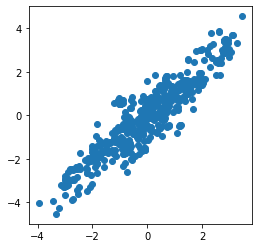

blood_HIGH_LIGHT_SCATTER_RETICULOCYTE_COUNT


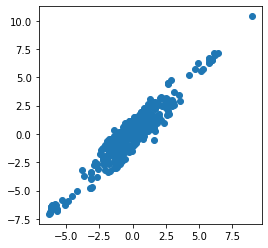

blood_LYMPHOCYTE_COUNT


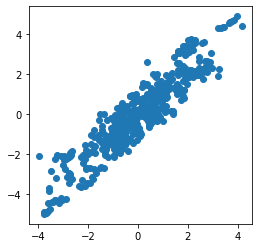

blood_MEAN_CORPUSCULAR_HEMOGLOBIN


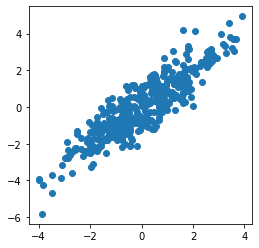

blood_MEAN_PLATELET_VOL


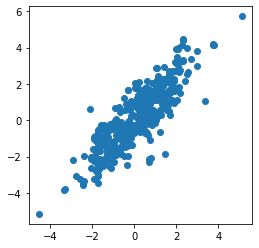

blood_MEAN_SPHERED_CELL_VOL


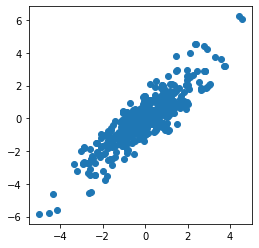

blood_MONOCYTE_COUNT


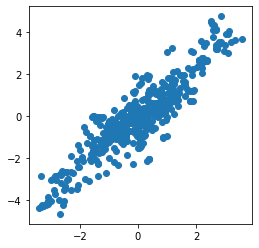

blood_PLATELET_COUNT


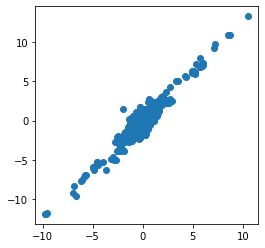

blood_PLATELET_DISTRIB_WIDTH


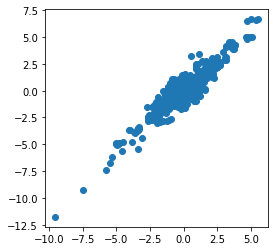

blood_RBC_DISTRIB_WIDTH


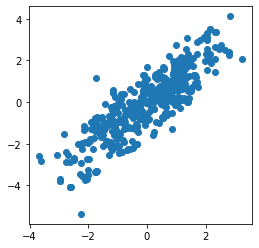

blood_RED_COUNT


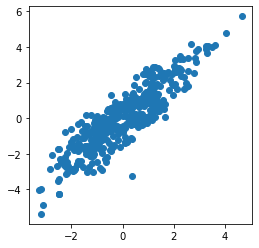

blood_WHITE_COUNT


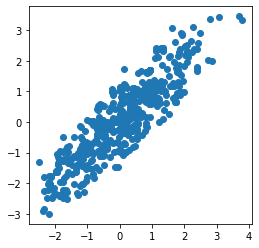

bmd_HEEL_TSCOREz


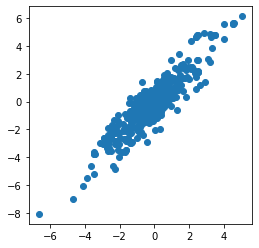

body_BALDING1


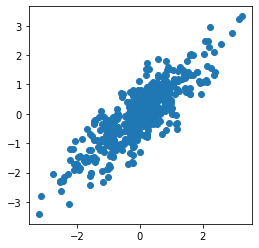

body_BALDING4


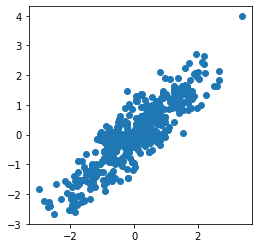

body_BMIz


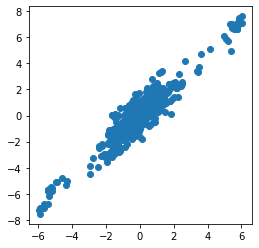

body_HEIGHTz


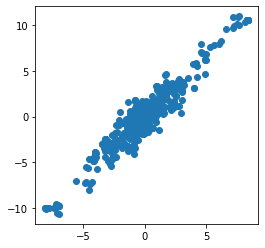

body_WHRadjBMIz


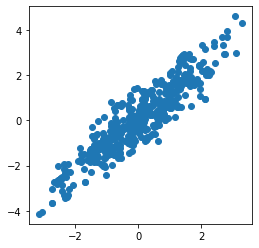

bp_DIASTOLICadjMEDz


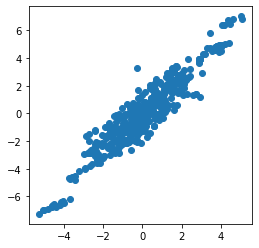

bp_SYSTOLICadjMEDz


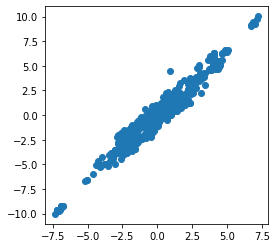

cancer_ALL


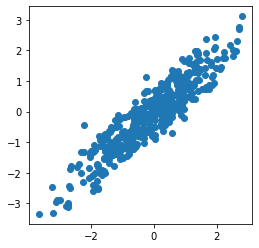

cancer_BREAST


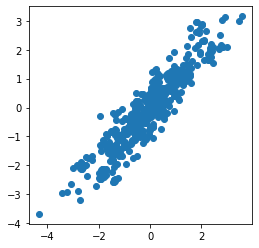

cancer_PROSTATE


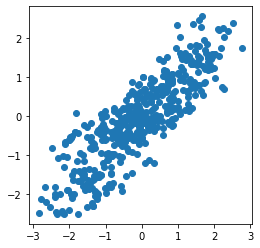

cov_EDU_COLLEGE


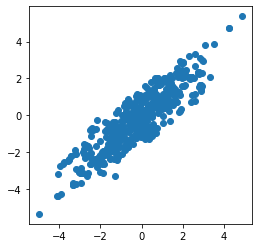

cov_EDU_YEARS


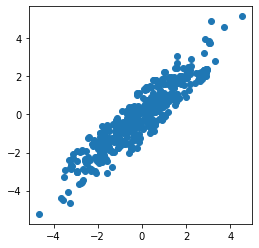

cov_SMOKING_STATUS


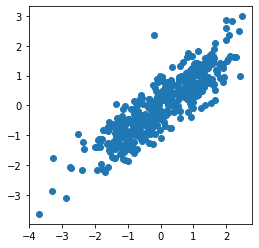

disease_AID_ALL


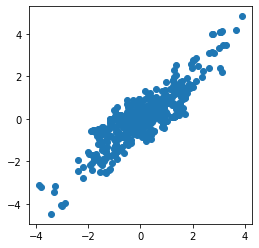

disease_AID_SURE


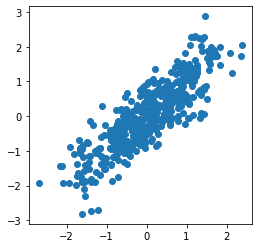

disease_ALLERGY_ECZEMA_DIAGNOSED


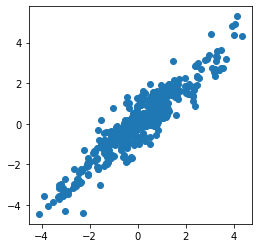

disease_ASTHMA_DIAGNOSED


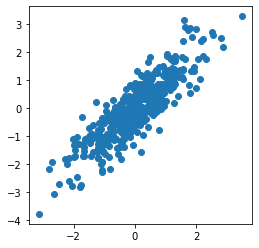

disease_CARDIOVASCULAR


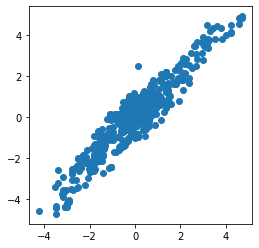

disease_DERMATOLOGY


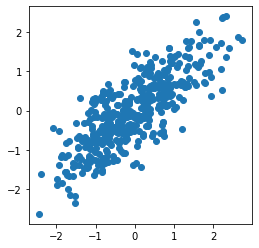

disease_DIABETES_ANY_DIAGNOSED


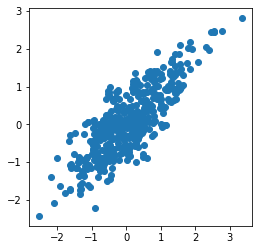

disease_ENDOCRINE_DIABETES


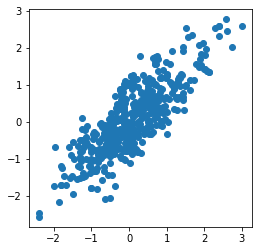

disease_HI_CHOL_SELF_REP


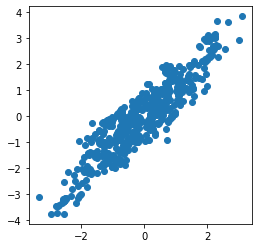

disease_HYPERTENSION_DIAGNOSED


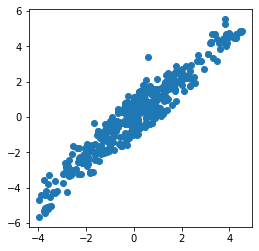

disease_HYPOTHYROIDISM_SELF_REP


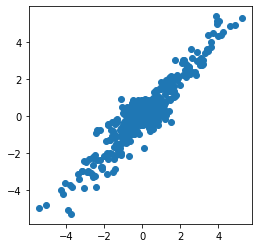

disease_PSORIASIS


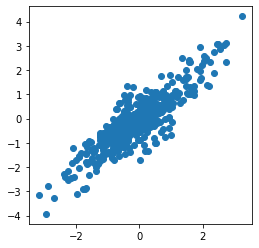

disease_RA


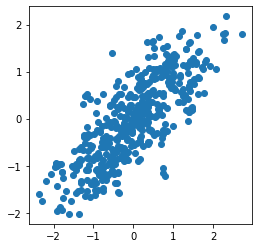

disease_RESPIRATORY_ENT


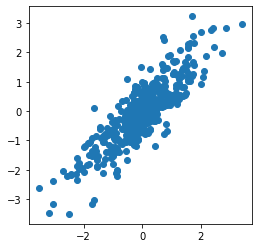

disease_T2D


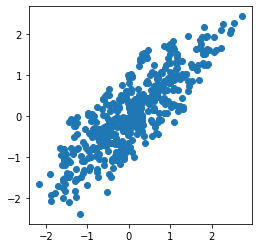

disease_THYROID_ANY_SELF_REP


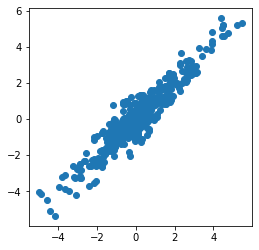

impedance_BASAL_METABOLIC_RATEz


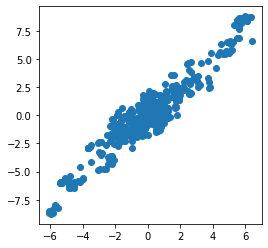

lung_FEV1FVCzSMOKE


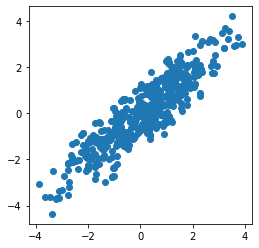

lung_FVCzSMOKE


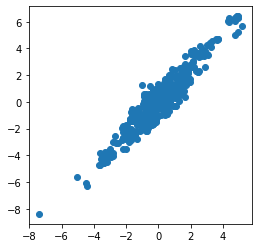

mental_NEUROTICISM


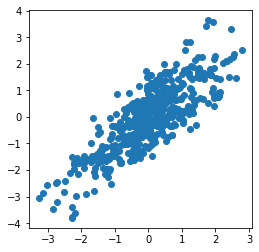

other_MORNINGPERSON


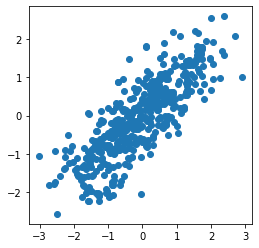

other_NO_WHEAT


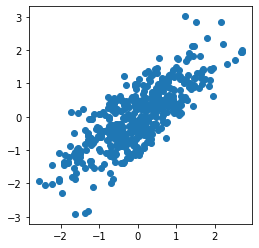

pigment_HAIR


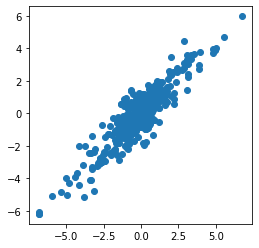

pigment_HAIR_blackmale


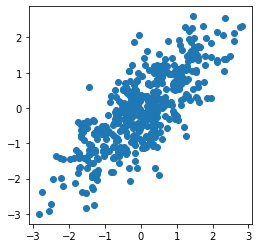

pigment_HAIR_blonde


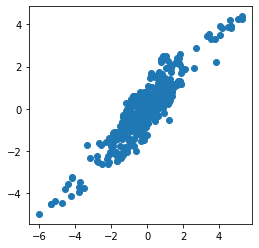

pigment_HAIR_darkbrown


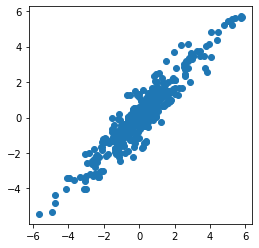

pigment_HAIR_red


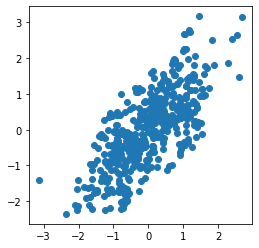

pigment_SKIN


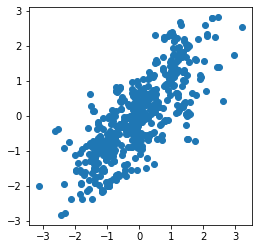

pigment_SUNBURN


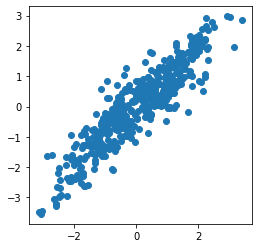

pigment_TANNING


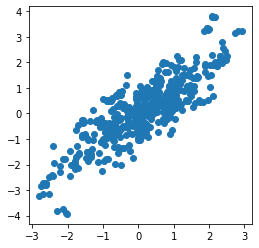

repro_AgeFirstBirth_Female


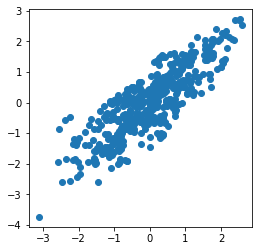

repro_MENARCHE_AGE


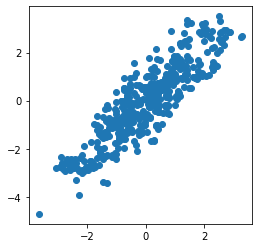

repro_MENOPAUSE_AGE


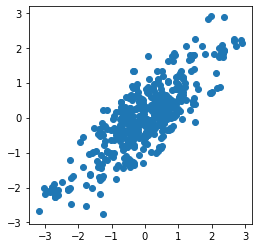

repro_NumberChildrenEverBorn_Pooled


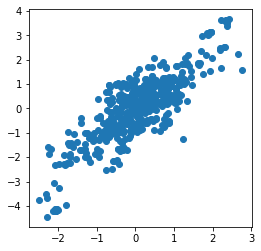

biochemistry_AlanineAminotransferase


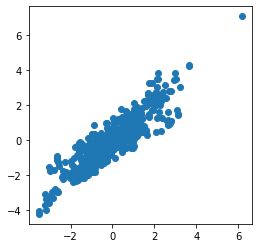

biochemistry_Albumin


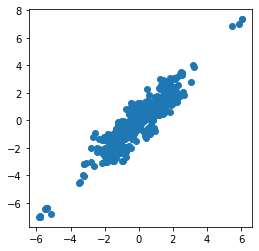

biochemistry_AlkalinePhosphatase


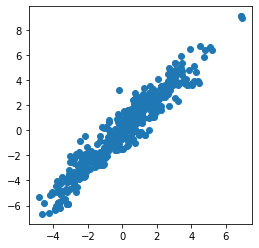

biochemistry_ApolipoproteinA


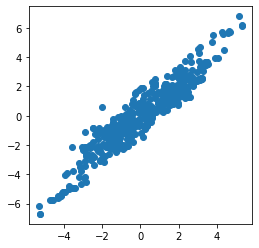

biochemistry_ApolipoproteinB


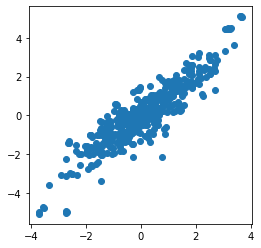

biochemistry_AspartateAminotransferase


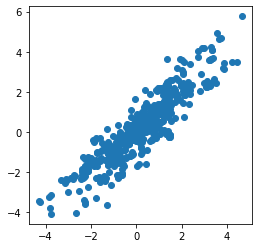

biochemistry_Calcium


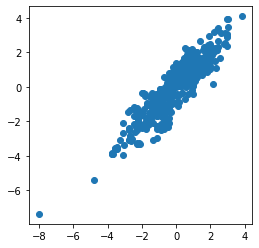

biochemistry_Cholesterol


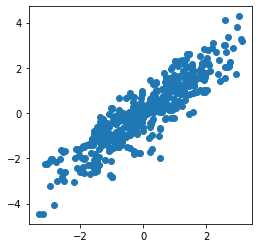

biochemistry_CreactiveProtein


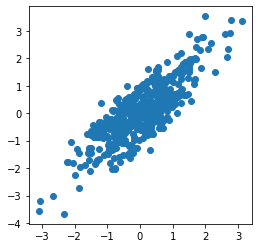

biochemistry_Creatinine


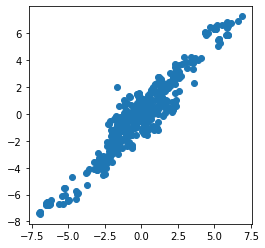

biochemistry_CystatinC


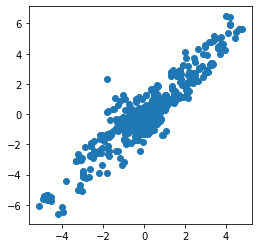

biochemistry_DirectBilirubin


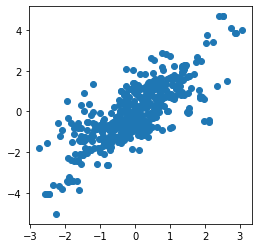

biochemistry_GammaGlutamyltransferase


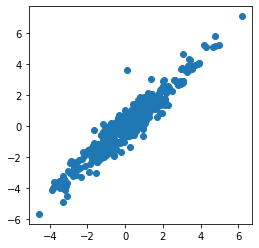

biochemistry_Glucose


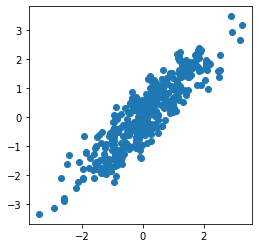

biochemistry_HDLcholesterol


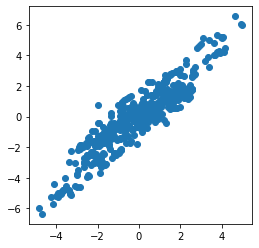

biochemistry_HbA1c


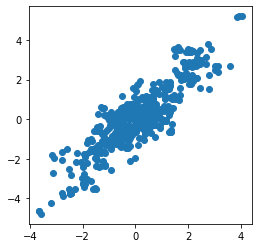

biochemistry_IGF1


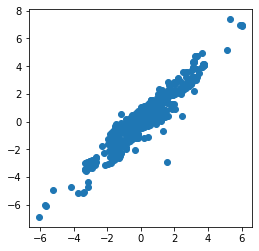

biochemistry_LDLdirect


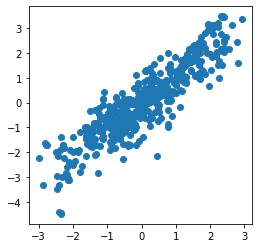

biochemistry_LipoproteinA


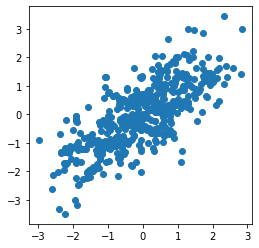

biochemistry_Phosphate


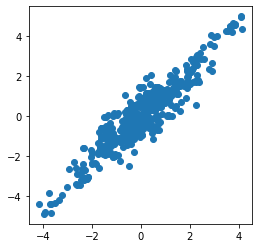

biochemistry_SHBG


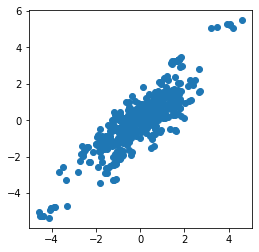

biochemistry_TotalBilirubin


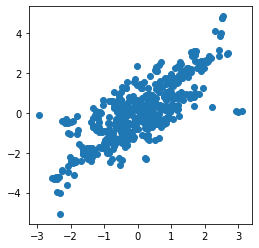

biochemistry_TotalProtein


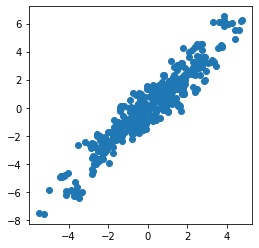

biochemistry_Triglycerides


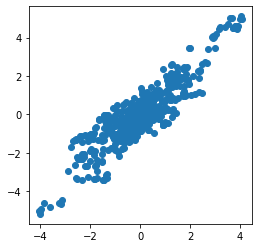

biochemistry_Urate


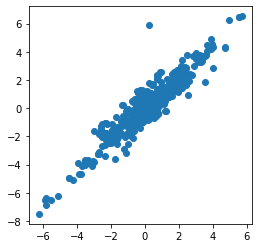

biochemistry_Urea


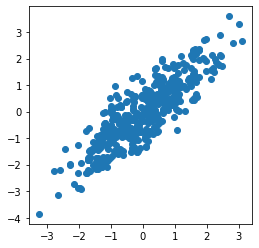

biochemistry_VitaminD


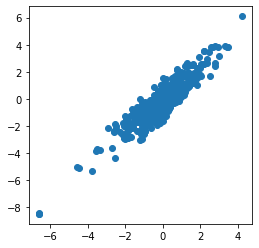

In [12]:
SUMSTATS_FILE = '/n/groups/price/martin/LDSPEC_data/UKBimp_337K_MAF001_chimp/sumstats/@.sumstats.gz'
SUMSTATS_FILE_REF = '/n/groups/price/ldsc/sumstats_formatted_2021/UKB_460K.@.sumstats'

for trait in TRAIT_LIST:
    sumstats_file = SUMSTATS_FILE.replace('@', trait)
    sumstats_file_ref = SUMSTATS_FILE_REF.replace('@', trait)
    if os.path.exists(sumstats_file) & os.path.exists(sumstats_file_ref):
        print(trait)
        df_sumstats = pd.read_csv(sumstats_file, sep="\t", index_col=None, nrows=10000)
        df_sumstats_ref = pd.read_csv(sumstats_file_ref, sep="\t", index_col=None, nrows=10000)

        df_sumstats.index = df_sumstats['SNP']
        df_sumstats_ref.index = df_sumstats_ref['SNP']

        temp_set = set(df_sumstats_ref['SNP'])
        snp_list = [x for x in df_sumstats['SNP'] if x in temp_set]

        df_sumstats = df_sumstats.loc[snp_list]
        df_sumstats_ref = df_sumstats_ref.loc[snp_list]

        temp_v = ((df_sumstats['A1']==df_sumstats_ref['A1'])-0.5)*2
        plt.figure(figsize=[4,4])
        plt.scatter(df_sumstats['Z'], df_sumstats_ref['Z'] * temp_v)
        plt.show()

### Unfinished .score.gz files

In [11]:
# Compare score
score_file = '/n/scratch3/users/j/jz286/imp_geno_chimp.score_annot/ukb_imp_v3.win1e6.c1_s0_e10000_score.tsv.gz'
score_file_ref = '/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001/gdreg_score_file/'\
    'baseline_165annots.c1_score.tsv.gz'
score_file = '/n/scratch3/users/j/jz286/imp_geno_chimp.score_pannot/pannot.win1e6.c1_s0_e10000_score.tsv.gz'
score_file_ref = '/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001/gdreg_score_file/pannot_prox/'\
    'pannot_prox.c1_score.tsv.gz'
df_score = pd.read_csv(score_file, sep='\t', nrows=11000)
df_score_ref = pd.read_csv(score_file_ref, sep='\t', nrows=11000)

temp_set = set(df_score_ref.index)
snp_list = [x for x in df_score.index if x in temp_set]
df1 = df_score.loc[snp_list].copy()
df2 = df_score_ref.loc[snp_list].copy()
score_list = [x for x in set(df1)&set(df2) if 'LD:' in x]
print('%s (%d) vs. %s (%d); overlap=%d' % (
    'a', df_score.shape[0], 'b', df_score_ref.shape[0], len(snp_list)
))
for score in np.random.choice(score_list, size=5):
    print('%-50s abs_dif=%0.5e corr=%0.5f' % (
        score, 
        np.absolute(df1[score]-df2[score]).sum() / np.absolute(df1[score]).sum(), 
        np.corrcoef(df1[score], df2[score])[0,1]
    ))

print('')

a (10000) vs. b (11000); overlap=10000
DLD:pAN:proxy_0_1000_common_lf                     abs_dif=6.80551e+00 corr=-0.46537
DLD:pAN:proxy_0_10000_lf_lf                        abs_dif=2.69616e+00 corr=0.85323
DLD:pAN:proxy_0_1000_lf_lf                         abs_dif=2.95910e+00 corr=0.83450
DLD:pAN:proxy_0_100_lf_lf                          abs_dif=1.62689e+00 corr=0.88431
DLD:pAN:proxy_0_100_lf_lf                          abs_dif=1.62689e+00 corr=0.88431



In [4]:
# annot
SNP_RANGE_FILE="/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001/ukb_imp_v3.snp_range.txt"
SNP_RANGE_FILE_UF="/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001_chimp/ukb_imp_v3.snp_range.annot.uf.txt"
SCORE_FILE="/n/scratch3/users/j/jz286/imp_geno_chimp.score_annot/ukb_imp_v3.win1e6.@_score.tsv.gz"

snp_range_list = []
with open(SNP_RANGE_FILE, "r") as f:
    for line in f:
        snp_range_list.append(line.strip())

snp_range_uf_list = []
for snp_range in snp_range_list:
    score_file = SCORE_FILE.replace("@", snp_range)
    if os.path.exists(score_file):
#         temp_df = pd.read_csv(score_file, sep="\t", index_col=None, nrows=5)
        temp_df = pd.read_csv(score_file, sep="\t", index_col=None)
        if temp_df.isna().sum().sum()==0:
            continue            
    snp_range_uf_list.append(snp_range)

with open(SNP_RANGE_FILE_UF, "w") as f:
    for snp_range in snp_range_uf_list:
        f.write("%s\n" % snp_range)
        
print("%d/%d unfinished" % (len(snp_range_uf_list), len(snp_range_list)))

0/1492 unfinished


In [5]:
# pannot
SNP_RANGE_FILE="/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001/ukb_imp_v3.snp_range.txt"
SNP_RANGE_FILE_UF="/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001_chimp/ukb_imp_v3.snp_range.pannot.uf.txt"
SCORE_FILE="/n/scratch3/users/j/jz286/imp_geno_chimp.score_pannot/pannot.win1e6.@_score.tsv.gz"

snp_range_list = []
with open(SNP_RANGE_FILE, "r") as f:
    for line in f:
        snp_range_list.append(line.strip())

snp_range_uf_list = []
for snp_range in snp_range_list:
    score_file = SCORE_FILE.replace("@", snp_range)
    if os.path.exists(score_file):
#         temp_df = pd.read_csv(score_file, sep="\t", index_col=None, nrows=5)
        temp_df = pd.read_csv(score_file, sep="\t", index_col=None)
        if temp_df.isna().sum().sum()==0:
            continue            
    snp_range_uf_list.append(snp_range)

with open(SNP_RANGE_FILE_UF, "w") as f:
    for snp_range in snp_range_uf_list:
        f.write("%s\n" % snp_range)
        
print("%d/%d unfinished" % (len(snp_range_uf_list), len(snp_range_list)))

0/1492 unfinished


In [2]:
# pannot_ld
SNP_RANGE_FILE="/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001/ukb_imp_v3.snp_range.txt"
SNP_RANGE_FILE_UF="/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001_chimp/ukb_imp_v3.snp_range.pannot_ld.uf.txt"
SCORE_FILE="/n/scratch3/users/j/jz286/imp_geno_chimp.score_pannot_ld/pannot.win1e6.@_score.tsv.gz"

snp_range_list = []
with open(SNP_RANGE_FILE, "r") as f:
    for line in f:
        snp_range_list.append(line.strip())

snp_range_uf_list = []
for snp_range in snp_range_list:
    score_file = SCORE_FILE.replace("@", snp_range)
    if os.path.exists(score_file):
#         temp_df = pd.read_csv(score_file, sep="\t", index_col=None, nrows=5)
        temp_df = pd.read_csv(score_file, sep="\t", index_col=None)
        if temp_df.isna().sum().sum()==0:
            continue            
    snp_range_uf_list.append(snp_range)

with open(SNP_RANGE_FILE_UF, "w") as f:
    for snp_range in snp_range_uf_list:
        f.write("%s\n" % snp_range)
        
print("%d/%d unfinished" % (len(snp_range_uf_list), len(snp_range_list)))

0/1492 unfinished


In [6]:
# baseline_0_100
SNP_RANGE_FILE="/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001/ukb_imp_v3.snp_range.txt"
SNP_RANGE_FILE_UF="/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001_chimp/ukb_imp_v3.snp_range.baseline_0_100.uf.txt"
SCORE_FILE="/n/scratch3/users/j/jz286/imp_geno_chimp.score_pannot_baseline_0_100/ukb_imp_v3.win1e6.@_score.tsv.gz"

snp_range_list = []
with open(SNP_RANGE_FILE, "r") as f:
    for line in f:
        snp_range_list.append(line.strip())

snp_range_uf_list = []
for snp_range in snp_range_list:
    score_file = SCORE_FILE.replace("@", snp_range)
    if os.path.exists(score_file):
#         temp_df = pd.read_csv(score_file, sep="\t", index_col=None, nrows=5)
        temp_df = pd.read_csv(score_file, sep="\t", index_col=None)
        if temp_df.isna().sum().sum()==0:
            continue            
    snp_range_uf_list.append(snp_range)

with open(SNP_RANGE_FILE_UF, "w") as f:
    for snp_range in snp_range_uf_list:
        f.write("%s\n" % snp_range)
        
print("%d/%d unfinished" % (len(snp_range_uf_list), len(snp_range_list)))

0/1492 unfinished


In [7]:
# baseline_0_1000
SNP_RANGE_FILE="/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001/ukb_imp_v3.snp_range.txt"
SNP_RANGE_FILE_UF="/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001_chimp/ukb_imp_v3.snp_range.baseline_0_1000.uf.txt"
SCORE_FILE="/n/scratch3/users/j/jz286/imp_geno_chimp.score_pannot_baseline_0_1000/ukb_imp_v3.win1e6.@_score.tsv.gz"

snp_range_list = []
with open(SNP_RANGE_FILE, "r") as f:
    for line in f:
        snp_range_list.append(line.strip())

snp_range_uf_list = []
for snp_range in snp_range_list:
    score_file = SCORE_FILE.replace("@", snp_range)
    if os.path.exists(score_file):
#         temp_df = pd.read_csv(score_file, sep="\t", index_col=None, nrows=5)
        temp_df = pd.read_csv(score_file, sep="\t", index_col=None)
        if temp_df.isna().sum().sum()==0:
            continue            
    snp_range_uf_list.append(snp_range)

with open(SNP_RANGE_FILE_UF, "w") as f:
    for snp_range in snp_range_uf_list:
        f.write("%s\n" % snp_range)
        
print("%d/%d unfinished" % (len(snp_range_uf_list), len(snp_range_list)))

0/1492 unfinished


### AVGR

In [6]:
PANNOT_FILE_LIST = [
    '/home/jz286/WES_analysis/LDSPEC/experiments/job.curate_data/pannot_list.070723/pannot_list_main.txt',
    '/home/jz286/WES_analysis/LDSPEC/experiments/job.curate_data/pannot_list.070723/pannot_list.baseline_0_100.txt',
    '/home/jz286/WES_analysis/LDSPEC/experiments/job.curate_data/pannot_list.070723/pannot_list.baseline_0_1000.txt',
    '/home/jz286/WES_analysis/LDSPEC/experiments/job.curate_data/pannot_list/pannot_list_basic.txt',  
    '/home/jz286/WES_analysis/LDSPEC/experiments/job.curate_data/pannot_list/pannot_list_gene.txt',  
    '/home/jz286/WES_analysis/LDSPEC/experiments/job.curate_data/pannot_list/pannot_list_baseline_0_100_ld.txt',
    '/home/jz286/WES_analysis/LDSPEC/experiments/job.curate_data/pannot_list/pannot_list_baseline_0_1000_ld.txt',
]
dic_avgr = {}
missing_list = []

for PANNOT_FILE in PANNOT_FILE_LIST:
    for fpath in pd.read_csv(PANNOT_FILE, header=None)[0]:
        if os.path.exists(fpath+'.avgr'):
            temp_df = pd.read_csv(fpath+'.avgr', header=None, sep='\t')
            dic_avgr[temp_df[0][0]] = temp_df[1][0]
        else:
            missing_list.append(fpath)
            print('Missing: %s' % fpath)
print('dic_avgr', len(dic_avgr))

with open("/n/groups/price/martin/LDSPEC_data/UKBimp_337K_MAF001_chimp/pannot/main.avgr", "w") as f:
    for pAN in dic_avgr:
        f.write("%s\t%0.6f\n" % (pAN, dic_avgr[pAN]))
        
with open('/n/groups/price/martin/LDSPEC_data/UKBimp_337K_MAF001_chimp/pannot/missing_avgr.txt', 'w') as f:
    for fpath in missing_list:
        f.write('%s\n' % fpath)

dic_avgr 228


### Check score files

In [2]:
SCORE_FILE = '/n/scratch3/users/j/jz286/imp_geno_chimp.score_pannot_baseline_0_1000_ld/ukb_imp_v3.c1_s0_e10000_score.tsv.gz'
SCORE_FILE_REF = '/n/groups/price/martin/LDSPEC_data/UKBimp_337K_MAF001_chimp/ldspec_score_file/pannot_baseline_0_1000.c1_score.tsv.gz'
SCORE_FILE = '/n/scratch3/users/j/jz286/imp_geno_chimp.score_pannot_gene/ukb_imp_v3.c1_s0_e10000_score.tsv.gz'
SCORE_FILE = '/n/groups/price/martin/LDSPEC_data/UKBimp_337K_MAF001_chimp/ldspec_score_file/pannot_gene_ld.c1_score.tsv.gz'
SCORE_FILE_REF = '/n/groups/price/martin/LDSPEC_data/UKBimp_337K_MAF001_chimp/ldspec_score_file/pannot.c1_score.tsv.gz'

df_score = pd.read_csv(SCORE_FILE, sep="\t", index_col=None, nrows=1000)
df_score_ref = pd.read_csv(SCORE_FILE_REF, sep="\t", index_col=None, nrows=1000)

# df_score.index = df_score['SNP']
# df_score_ref.index = df_score_ref['SNP']

# temp_set = set(df_score_ref['SNP'])
# snp_list = [x for x in df_score['SNP'] if x in temp_set]

# df_score = df_score.loc[snp_list]
# df_score_ref = df_score_ref.loc[snp_list]

# # mbin_list = ["LD:AN:mbin%d_%s" % (y,x) for x in ["common", "lf"] for y in range(5)]
# # df_score['LD:all'] = df_score[mbin_list].sum(axis=1)

# plt.figure(figsize=[5,5])
# plt.scatter(df_score['LD:AN:all'], df_score_ref['baseL2'])
# plt.title('Total LD score')
# plt.show()

# plt.figure(figsize=[5,5])
# plt.scatter(df_score['LD:AN:recomb_rate_common'] + df_score['LD:AN:recomb_rate_lf'], 
#             df_score_ref['Recomb_Rate_10kbL2'])
# plt.title('Recomb_Rate_10kbL2')
# plt.show()

In [5]:
df_score[['DLD:pAN:exon_ld_p0_p100_maf_common_block',
          'DLD:pAN:exon_ld_n100_p0_maf_common_block'
         ]].sum(axis=1)

0      0.012600
1     -0.052548
2     -0.001650
3      0.034206
4      0.041732
         ...   
995    0.018110
996    0.030773
997    0.014786
998   -0.009717
999   -3.826250
Length: 1000, dtype: float64

In [5]:
df_score[['DLD:pAN:exon_ld_p0_p100_maf_common_block', 'DLD:pAN:exon_ld_n100_maf_common_block']]

,CHR,SNP,BP,E,DLD:pAN:exon_ld_full_maf_common_block,DLD:pAN:exon_ld_full_maf_lf_block,DLD:pAN:exonic_gene_ld_full_maf_common_block,DLD:pAN:exonic_gene_ld_full_maf_lf_block,DLD:pAN:cS2G_promoter_ld_full_maf_common_block,DLD:pAN:cS2G_promoter_ld_full_maf_lf_block,...,DLD:pAN:exon_ld_n100_p0_maf_common_block,DLD:pAN:exon_ld_n100_p0_maf_lf_block,DLD:pAN:exonic_gene_ld_n100_p0_maf_common_block,DLD:pAN:exonic_gene_ld_n100_p0_maf_lf_block,DLD:pAN:cS2G_promoter_ld_n100_p0_maf_common_block,DLD:pAN:cS2G_promoter_ld_n100_p0_maf_lf_block,DLD:pAN:protein_domain_ld_n100_p0_maf_common_block,DLD:pAN:protein_domain_ld_n100_p0_maf_lf_block,DLD:pAN:gene_ld_n100_p0_maf_common_block,DLD:pAN:gene_ld_n100_p0_maf_lf_block
0,1,1:66435_ATT_A,66435,0.999023,0.012600,0.003350,0.053225,0.001583,0.004053,-0.104831,...,-0.056997,-0.079583,-0.165061,-0.087142,-0.142284,-0.967603,-0.009245,-0.000447,-5.068295,-5.242253
1,1,rs555652149,70352,0.988138,-0.052548,-0.006444,0.075635,0.004504,0.182237,0.012554,...,-0.251670,0.000076,-0.935377,0.008351,-1.527358,0.004941,-0.165692,0.003596,-22.945170,-0.221392
2,1,rs531531651,85988,0.995694,-0.001650,-0.000163,0.029241,0.022253,0.002265,-0.000327,...,-0.069760,-0.008240,-0.106905,-0.037182,-0.267911,-0.017935,-0.005707,-0.005548,-14.894493,-1.530589
3,1,rs185487977,88370,0.989844,0.034206,0.018708,0.033692,0.001661,-0.030582,0.082329,...,-0.053305,-0.013895,-0.195693,-0.036309,-0.164989,-0.004588,-0.004675,-0.005688,-6.442740,-0.399427
4,1,rs548107800,98608,0.993152,0.041732,-0.000476,0.112401,-0.000316,0.025306,-0.003246,...,-0.056087,-0.004292,-0.183119,-0.006074,-0.038822,-0.006156,-0.001272,-0.000518,-2.733769,-0.214939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,rs555071784,913422,0.975607,0.018110,-0.015121,0.084335,-0.025783,0.007969,0.156367,...,-0.039140,-0.023163,-0.079869,-0.049110,-0.362535,-0.075395,-0.008077,-0.001536,-24.357605,-2.250077
996,1,1:913425_CA_C,913425,0.967711,0.030772,-0.017158,-3.361193,-0.254101,-0.542105,-0.167099,...,-2.028227,-0.094603,-8.449268,-0.459589,-8.866612,-1.044726,-0.400485,-0.202066,-438.385280,-15.980523
997,1,rs540371076,913605,0.982400,0.014786,-0.007217,0.004756,-0.009394,0.030306,0.011219,...,-0.026563,-0.008581,-0.076453,-0.023435,-0.187736,-0.011500,0.000449,-0.021050,-7.521775,-0.785284
998,1,rs564834117,913606,0.992205,-0.009717,0.003813,-0.013202,0.004899,-0.008275,0.026662,...,-0.071692,0.002672,-0.176875,-0.006753,-0.143845,0.015248,-0.007256,-0.015211,-5.141668,-0.648930


In [6]:
df_score_ref['DLD:pAN:exon_common_common']

0      0.012600
1     -0.052548
2     -0.001650
3      0.034206
4      0.041732
         ...   
995    0.018110
996    0.030772
997    0.014786
998   -0.009717
999   -3.826256
Name: DLD:pAN:exon_common_common, Length: 1000, dtype: float64

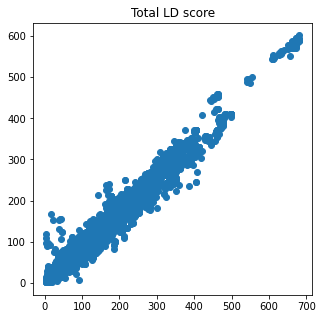

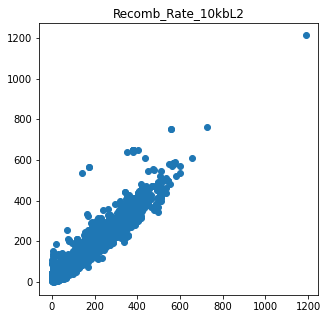

In [7]:
SCORE_FILE = '/n/scratch3/users/j/jz286/imp_geno_chimp.score_pannot_baseline_0_100_ld/ukb_imp_v3.c1_s0_e10000_score.tsv.gz'
SCORE_FILE_REF = '/n/groups/price/ldsc/reference_files/1000G_EUR_Phase3/baselineLD_v2.2/baselineLD.22.l2.ldscore.gz'

df_score = pd.read_csv(SCORE_FILE, sep="\t", index_col=None)
df_score_ref = pd.read_csv(SCORE_FILE_REF, sep="\t", index_col=None)

df_score.index = df_score['SNP']
df_score_ref.index = df_score_ref['SNP']

temp_set = set(df_score_ref['SNP'])
snp_list = [x for x in df_score['SNP'] if x in temp_set]

df_score = df_score.loc[snp_list]
df_score_ref = df_score_ref.loc[snp_list]

# mbin_list = ["LD:AN:mbin%d_%s" % (y,x) for x in ["common", "lf"] for y in range(5)]
# df_score['LD:all'] = df_score[mbin_list].sum(axis=1)

plt.figure(figsize=[5,5])
plt.scatter(df_score['LD:AN:all'], df_score_ref['baseL2'])
plt.title('Total LD score')
plt.show()

plt.figure(figsize=[5,5])
plt.scatter(df_score['LD:AN:recomb_rate_common'] + df_score['LD:AN:recomb_rate_lf'], 
            df_score_ref['Recomb_Rate_10kbL2'])
plt.title('Recomb_Rate_10kbL2')
plt.show()

### Combine and write score files

In [3]:
# Write as per-CHR score files
SNP_RANGE_FILE="/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001/ukb_imp_v3.snp_range.txt"
snp_range_list = []
with open(SNP_RANGE_FILE, "r") as f:
    for line in f:
        snp_range_list.append(line.strip())

for SCORE_FILE,PREFIX_OUT in [
#     [
#     "/n/scratch3/users/j/jz286/imp_geno_chimp.score_annot/ukb_imp_v3.win1e6.@_score.tsv.gz", 
#     "/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001_chimp/gdreg_score_file/baseline",
# ], 
#     [
#     "/n/scratch3/users/j/jz286/imp_geno_chimp.score_pannot/pannot.win1e6.@_score.tsv.gz",
#     "/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001_chimp/gdreg_score_file/pannot",
# ], 
    [
    "/n/scratch3/users/j/jz286/imp_geno_chimp.score_pannot_ld/pannot.win1e6.@_score.tsv.gz",
    "/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001_chimp/gdreg_score_file/pannot_ld",
], 
#     [
#     "/n/scratch3/users/j/jz286/imp_geno_chimp.score_pannot_baseline_0_100/ukb_imp_v3.win1e6.@_score.tsv.gz",
#     "/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001_chimp/gdreg_score_file/pannot_baseline_0_100",
# ],
#     [
#     "/n/scratch3/users/j/jz286/imp_geno_chimp.score_pannot_baseline_0_1000/ukb_imp_v3.win1e6.@_score.tsv.gz",
#     "/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001_chimp/gdreg_score_file/pannot_baseline_0_1000",
# ],
]:
    print(SCORE_FILE)
    print(PREFIX_OUT)
    for CHR in range(1,23):
#     for CHR in [22]:
        snp_range_list_chr = [x for x in snp_range_list if x.startswith("c%s_" % CHR)]
        df_list = []
        for snp_range in snp_range_list_chr:
            df_list.append(pd.read_csv(SCORE_FILE.replace("@", snp_range), sep="\t", index_col=None))
        df_score_chr = pd.concat(df_list, axis=0)    
        col_list = [x for x in df_score_chr if x.startswith(("E", "LD", "DLD"))]
        df_score_chr[col_list] = df_score_chr[col_list].astype(np.float32)
        df_score_chr.to_csv(PREFIX_OUT + ".c%d_score.tsv.gz" % CHR, sep="\t", index=False, compression="gzip")
        print(
            "CHR%d"%CHR,
            "n_file=%d" % len(snp_range_list_chr),
            "n_snp=%d" % df_score_chr.shape[0],
            "n_col=%d" % df_score_chr.shape[1],
            "n_na=%d" % df_score_chr.isna().sum().sum(),
        )
    print("")

/n/scratch3/users/j/jz286/imp_geno_chimp.score_pannot_ld/pannot.win1e6.@_score.tsv.gz
/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001_chimp/gdreg_score_file/pannot_ld
CHR1 n_file=117 n_snp=1161341 n_col=13 n_na=0
CHR2 n_file=126 n_snp=1259312 n_col=13 n_na=0
CHR3 n_file=106 n_snp=1059605 n_col=13 n_na=0
CHR4 n_file=108 n_snp=1074447 n_col=13 n_na=0
CHR5 n_file=97 n_snp=964806 n_col=13 n_na=0
CHR6 n_file=98 n_snp=976090 n_col=13 n_na=0
CHR7 n_file=87 n_snp=868301 n_col=13 n_na=0
CHR8 n_file=83 n_snp=826076 n_col=13 n_na=0
CHR9 n_file=65 n_snp=641608 n_col=13 n_na=0
CHR10 n_file=75 n_snp=747773 n_col=13 n_na=0
CHR11 n_file=74 n_snp=730385 n_col=13 n_na=0
CHR12 n_file=71 n_snp=705493 n_col=13 n_na=0
CHR13 n_file=54 n_snp=537961 n_col=13 n_na=0
CHR14 n_file=49 n_snp=482519 n_col=13 n_na=0
CHR15 n_file=43 n_snp=423991 n_col=13 n_na=0
CHR16 n_file=47 n_snp=465661 n_col=13 n_na=0
CHR17 n_file=41 n_snp=406065 n_col=13 n_na=0
CHR18 n_file=43 n_snp=422346 n_col=13 n_na=0
CHR19 n_file=34 n_s

### reg_annot_file

In [7]:
for file in ['reg_annot_file.proxy.txt', 'reg_annot_file.proxy_0_10000.txt']:
    print(file)
    with open(file, 'r') as f:
        for line in f:
            line = line.strip()
            for CHR in range(1, 23):
                if os.path.exists(line.replace('@', '%d' % CHR)) is False:
                    print('    %s' % line)
            

reg_annot_file.proxy.txt
reg_annot_file.proxy_0_10000.txt


### Unfinished res files

In [4]:
TRAIT_FILE='/n/groups/price/martin/LDSPEC_data/UKBB_trait/trait_list_all.txt'
TRAIT_FILE='/n/groups/price/martin/LDSPEC_data/UKBB_trait/trait_list_all_indpt.txt'
RES_FILE='/n/groups/price/martin/LDSPEC_data/UKBimp_337K_MAF001_chimp/ldspec_res_070223.proxno_gene_fct/@.pickle'
RES_FILE='/n/groups/price/martin/LDSPEC_data/UKBimp_337K_MAF001_chimp/ldspec_res_070223.bsl/@.pickle'

trait_list = []
with open(TRAIT_FILE, "r") as f:
    for line in f:
        trait_list.append(line.strip())

trait_uf_list = []
for i_trait,trait in enumerate(trait_list):
    res_file = RES_FILE.replace("@", trait)
    if os.path.exists(res_file):
        continue            
    else:
        print(i_trait+1, trait)
#     trait_uf_list.append(trait)

# with open(TRAIT_FILE_UF, "w") as f:
#     for trait in trait_uf_list:
#         f.write("%s\n" % trait)
        
print("%d/%d unfinished" % (len(trait_uf_list), len(trait_list)))

28 biochemistry_IGF1
0/32 unfinished


### Null model file

In [5]:
pd.read_csv('/n/groups/price/martin/LDSPEC_data/UKBimp_337K_MAF001_chimp/sumstats/'
            'blood_LYMPHOCYTE_COUNT.nomhc.sumstats.gz', sep='\t')

OSError: CRC check failed 0x1a605127 != 0x67ccb4da